<a href="https://colab.research.google.com/github/UXDynamicSolution/seriesTemporales/blob/main/series_temporales_con_Python_y_Scikit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Series temporales con Python y Scikit-learn
Una serie temporal (time series) es una sucesión de datos ordenados cronológicamente, espaciados a intervalos iguales o desiguales. El proceso de forecasting consiste en predecir el valor futuro de una serie temporal, bien modelando la serie únicamente en función de su comportamiento pasado (autorregresivo) o empleando otras variables externas.

A lo largo de este documento, se describe cómo utilizar modelos de regresión de Scikit-learn para realizar forecasting sobre series temporales. En concreto, se hace uso de Skforecast, una librería que contiene las clases y funciones necesarias para adaptar cualquier modelo de regresión de Scikit-learn a problemas de forecasting.

# Entrenar un modelo de pronóstico

La principal adaptación que se necesita hacer para aplicar modelos de machine learning a problemas de forecasting es transformar la serie temporal en un matriz en la que, cada valor, está asociado a la ventana temporal (lags) que le precede.

Este tipo de transformación también permite incluir variables exógenas a la serie temporal.


Una vez que los datos se encuentran reordenados de esta forma, se puede entrenar cualquier modelo de regresión para que aprenda a predecir el siguiente valor de la serie.


# Predicciones multi-step

Cuando se trabaja con series temporales, raramente se quiere predecir solo el siguiente elemento de la serie ( t+1 ), sino todo un intervalo futuro o un punto alejado en el tiempo ( t+n ). A cada paso de predicción se le conoce como step. Existen varias estrategias que permiten generar este tipo de predicciones múltiples.

# Recursive multi-step forecasting

Dado que, para predecir el momento  tn  se necesita el valor de  tn−1 , y  tn−1  se desconoce, se sigue un proceso recursivo en el que, cada nueva predicción, hace uso de la predicción anterior. A este proceso se le conoce como recursive forecasting o recursive multi-step forecasting y pueden generarse fácilmente con las clases ForecasterAutoreg y ForecasterAutoregCustom de la librería skforecast.

# Direct multi-step forecasting

El método direct multi-step forecasting consiste en entrenar un modelo distinto para cada step. Por ejemplo, si se quieren predecir los siguientes 5 valores de una serie temporal, se entrenan 5 modelos distintos, uno para cada step. Como resultado, las predicciones son independientes unas de otras.

La principal complejidad de esta aproximación consiste en generar correctamente las matrices de entrenamiento para cada modelo. Todo este proceso está automatizado en la clase ForecasterAutoregMultiOutput de la librería skforecast. También es importante tener en cuenta que esta estrategia tiene un coste computacional más elevado ya que requiere entrenar múltiples modelos. En el siguiente esquema se muestra el proceso para un caso en el que se dispone de la variable respuesta y dos variables exógenas.

# Multiple output forecasting

Determinados modelos, por ejemplo, las redes neuronales LSTM, son capaces de predecir de forma simultánea varios valores de una secuencia (one-shot). Esta estrategia no está disponible en skforecast.

# Forecasting autorregresivo recursivo

Se dispone de una serie temporal con el gasto mensual (millones de dólares) en fármacos con corticoides que tuvo el sistema de salud Australiano entre 1991 y 2008. Se pretende crear un modelo autoregresivo capaz de predecir el futuro gasto mensual.

# Librerías

Las librerías utilizadas en este documento son:



In [2]:
pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 5.0 MB/s 
     |████████████████████████████████| 9.8 MB 28.8 MB/s 
     |████████████████████████████████| 76 kB 5.0 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.0
    Uninstalling tqdm-4.64.0:
      Successfully uninstalled tqdm-4.64.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# Configuración warnings
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

# Datos

Los datos empleados en los ejemplos de este documento se han obtenido del magnífico libro Forecasting: Principles and Practice by Rob J Hyndman and George Athanasopoulos.

In [4]:
# Descarga de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
datos = pd.read_csv(url, sep=',')

La columna fecha se ha almacenado como string. Para convertirla en datetime, se emplea la función pd.to_datetime(). Una vez en formato datetime, y para hacer uso de las funcionalidades de Pandas, se establece como índice. Además, dado que los datos son mensuales, se indica la frecuencia (Monthly Started 'MS').

In [5]:
# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos.sort_index()
datos.head()

,y,exog_1,exog_2
fecha,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199


Al establecer una frecuencia con el método asfreq(), Pandas completa los huecos que puedan existir en la serie temporal con el valor de Null con el fin de asegurar la frecuencia indicada, ejemplo. Por ello, se debe comprobar si han aparecido missing values tras esta transformación.

In [6]:
print(f'Número de filas con missing values: {datos.isnull().any(axis=1).mean()}')


Número de filas con missing values: 0.0


Aunque no es necesario al haber establecido un frecuencia, se puede verificar que la serie temporal esté completa.



In [7]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(
                    start = datos.index.min(),
                    end   = datos.index.max(),
                    freq  = datos.index.freq)
).all()

True

Se utilizan los últimos 36 meses como conjunto de test para evaluar la capacidad predictiva del modelo:

In [8]:

# Completar huecos en un índice temporal
# ==============================================================================
# datos.asfreq(freq='30min', fill_value=np.nan)

Fechas train : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Fechas test  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


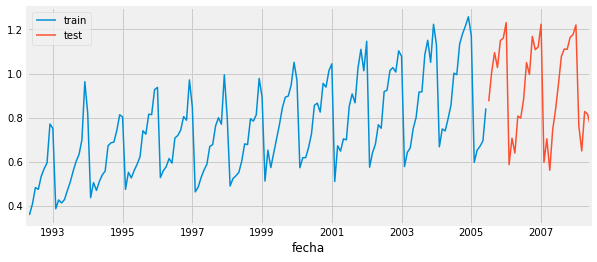

In [9]:
# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
ax.legend();

# ForecasterAutoreg

Se crea y entrena un modelo ForecasterAutoreg a partir de un regresor RandomForestRegressor y una ventana temporal de 6 lags. Esto último significa que, el modelo, utiliza como predictores los 6 meses anteriores.

In [10]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )

forecaster.fit(y=datos_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-08-09 06:37:21 
Last fit date: 2022-08-09 06:37:21 
Skforecast version: 0.4.3 

# Predicciones
Una vez entrenado el modelo, se predicen los datos de test (36 meses a futuro).



In [11]:
# Predicciones
# ==============================================================================
steps = 36
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

2005-07-01    0.878756
2005-08-01    0.882167
2005-09-01    0.973184
2005-10-01    0.983678
2005-11-01    0.849494
Freq: MS, Name: pred, dtype: float64

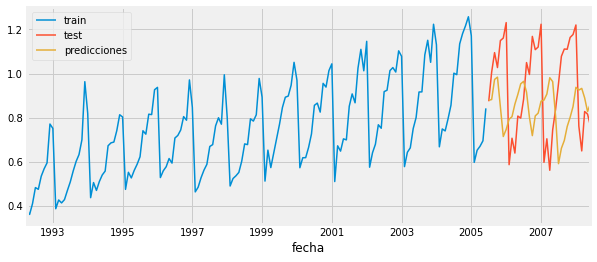

In [12]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

# Error de las predicciones en el conjunto de test
Se cuantifica el error que comete el modelo en sus predicciones. En este caso, se emplea como métrica el mean squared error (mse).

In [14]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 0.07326833976120374


# Ajuste de hiperparámetros (tuning)

El ForecasterAutoreg entrenado ha utilizado una ventana temporal de 6 lags y un modelo Random Forest con los hiperparámetros por defecto. Sin embargo, no hay ninguna razón por la que estos valores sean los más adecuados. Para identificar la mejor combinación de lags e hiperparámetros, la librería Skforecast dispone de la función grid_search_forecaster con la que comparar los resultados obtenidos con cada configuración del modelo.

Para una documentación más detallada, visitar:

[grid_search_forecaster](https://joaquinamatrodrigo.github.io/skforecast/0.4.3/notebooks/grid-search-forecaster.html)

In [15]:
# Grid search de hiperparámetros
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [10, 20]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:42<00:00, 21.34s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.012836389345193383



Los mejores resultados se obtienen si se utiliza una ventana temporal de 20 lags y una configuración de Random Forest {'max_depth': 3, 'n_estimators': 500}.

In [ ]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

# Modelo final

Finalmente, se entrena de nuevo un ForecasterAutoreg con la configuración óptima encontrada mediante validación. Este paso no es necesario si se indica return_best = True en la función grid_search_forecaster.

In [16]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=datos_train['y'])

In [17]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps)

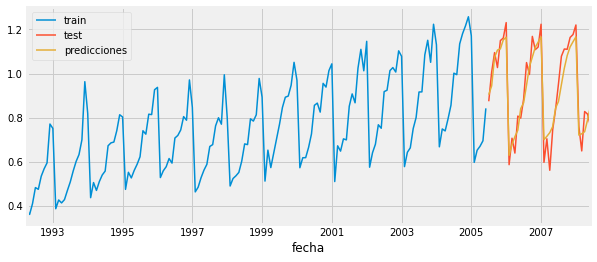

In [18]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [19]:
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse) {error_mse}")

Error de test (mse) 0.004392699665157793


Con la combinación óptima de hiperparámetros se consigue reducir notablemente el error de test.


# Backtesting

El proceso de backtesting consiste en evaluar el comportamiento de un modelo predictivo al aplicarlo de forma retrospectiva sobre datos históricos. Por lo tanto, es una estrategia de validación que permite cuantificar la capacidad predictiva de un modelo.


# Backtesting con reentrenamiento
El modelo se entrena cada vez antes de realizar las predicciones, de esta forma, se incorpora toda la información disponible hasta el momento. Se trata de una adaptación del proceso de cross-validation en el que, en lugar de hacer un reparto aleatorio de las observaciones, el conjunto de entrenamiento se incrementa de manera secuencial, manteniendo el orden temporal de los datos.


# Backtesting con reentrenamiento y tamaño de entrenamiento constante
Similar a la estrategia anterior, pero, en este caso, el tamaño del conjunto de entrenamiento no se incrementa sino que la ventana de tiempo que abarca se desplaza. Esta estrategia se conoce también como time series cross-validation o walk-forward validation.

# Backtesting sin reentrenamiento
Con esta estrategia, el modelo se entrena una única vez con un conjunto inicial y se realizan las predicciones de forma secuencial sin actualizar el modelo y siguiendo el orden temporal de los datos. Esta estrategia tiene la ventaja de ser mucho más rápida puesto que el modelo solo se entrena una vez. La desventaja es que el modelo no incorpora la última información disponible por lo que puede perder capacidad predictiva con el tiempo.

La librería skforecast tiene implementadas las estrategias de backtesting mencionadas. Independientemente de cuál se utilice, es importante no incluir los datos de test en el proceso de búsqueda para no caer en problemas de overfitting.

Para este ejemplo, se sigue una estrategia de backtesting con reentrenamiento. Internamente, el proceso seguido por la función es el siguiente:



*   En la primera iteración, el modelo se entrena con las observaciones Elemento de la lista seleccionadas para el entrenamiento inicial (en este caso, 87). Después, las siguientes 36 observaciones se utilizan para validar las predicciones de este primer modelo (también 36).

* En la segunda iteración, se reentrena el modelo añadiendo, al conjunto de entrenamiento inicial, las 36 observaciones de validación anteriores (87 + 36). De la misma manera, se establece como nuevo conjunto de validación las 36 observaciones siguientes.

* Este proceso se repite hasta que se utilizan todas las observaciones disponibles. Siguiendo esta estrategia, el conjunto de entrenamiento aumenta en cada iteración con tantas observaciones como steps se estén prediciendo.

In [20]:
# Backtesting
# ==============================================================================
steps = 36
n_backtesting = 36*3 # Se separan para el backtest los últimos 9 años

metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = datos['y'],
                                    initial_train_size = len(datos) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                                 )

print(f"Error de backtest: {metrica}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: 0.010578977232387663


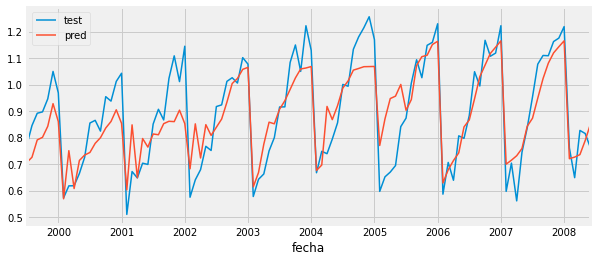

In [21]:
fig, ax = plt.subplots(figsize=(9, 4))
datos.loc[predicciones_backtest.index, 'y'].plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predicciones')
ax.legend();

# Importancia predictores

Dado que el objeto ForecasterAutoreg utiliza modelos scikit-learn, una vez entrenado, se puede acceder a la importancia de los predictores. Cuando el regresor empleado es un LinearRegression, Lasso o Ridge, la importancia queda reflejada en los coeficientes del modelo. En regresores como GradientBoostingRegressor, RandomForestRegressor o HistGradientBoostingRegressor, la importancia de los predictores está basada en la reducción de impureza.

Nota: el método get_feature_importance() solo devuelve valores si el regresor utilizado dentro del forecaster tiene el atributo coef_ o feature_importances_.

In [22]:
# Importancia predictores
# ==============================================================================
impotancia = forecaster.get_feature_importance()
impotancia

,feature,importance
0,lag_1,0.009412
1,lag_2,0.087268
2,lag_3,0.012754
3,lag_4,0.001446
4,lag_5,0.000401
5,lag_6,0.001386
6,lag_7,0.001273
7,lag_8,0.006926
8,lag_9,0.005839
9,lag_10,0.013076


# Forecasting autorregresivo recursivo con variables exógenas

En el ejemplo anterior, se han utilizado como predictores únicamente lags de la propia variable predicha. En ciertos escenarios, es posible disponer de información sobre otras variables, cuyo valor a futuro se conoce, y pueden servir como predictoreres adicionales en el modelo.

Siguiendo con el ejemplo anterior, se simula una nueva variable cuyo comportamiento está correlacionado con la serie temporal modelada y que, por lo tanto, se quiere incorporar como predictor. Esto mísmo es aplicable a múltiples variables exógenas.

# Datos

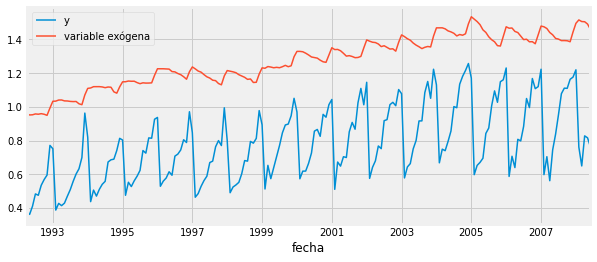

In [23]:
# Descarga de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
datos = pd.read_csv(url, sep=',')

# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.asfreq('MS')
datos = datos.sort_index()

fig, ax = plt.subplots(figsize=(9, 4))
datos['y'].plot(ax=ax, label='y')
datos['exog_1'].plot(ax=ax, label='variable exógena')
ax.legend();

In [24]:
# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Fechas test  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


# ForecasterAutoreg


In [25]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 8
             )

forecaster.fit(y=datos_train['y'], exog=datos_train['exog_1'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Window size: 8 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: exog_1 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-08-09 06:47:16 
Last fit date: 2022-08-09 06:47:16 
Skforecast version: 0.4.3 

# Predicciones

Si el ForecasterAutoreg se entrena con una variable exógena, hay que pasarle el valor de esta variable al predict(). Por lo tanto, solo es aplicable a escenarios en los que se dispone de información a futuro de la variable exógena.

In [26]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps, exog=datos_test['exog_1'])

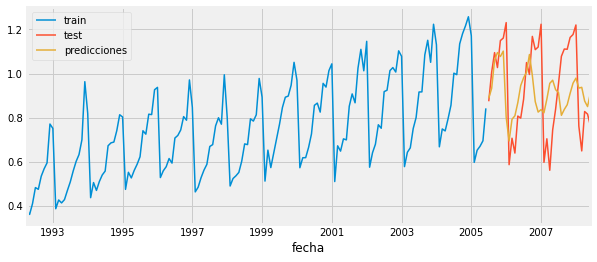

In [27]:
# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

# Error de las predicciones en el conjunto de test

In [28]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 0.03989087922533575


# Tuning del modelo

In [30]:

# Grid search de hiperparámetros
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

lags_grid = [5, 12, 20]

param_grid = {'n_estimators': [50, 100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['y'],
                        exog               = datos_train['exog_1'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                    )

Number of models compared: 27


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [01:10<00:00, 23.48s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 10, 'n_estimators': 50}
  Backtesting metric: 0.011894059611047655



In [31]:
# Resultados Grid Search
# ==============================================================================
resultados_grid.head()

,lags,params,metric,max_depth,n_estimators
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 50}",0.011894,10,50
16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 100}",0.012698,10,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 3, 'n_estimators': 50}",0.012836,3,50
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.012845,3,500
17,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 500}",0.012945,10,500


Los mejores resultados se obtienen utilizando una ventana temporal de 12 lags y una configuración de Random Forest {'max_depth': 10, 'n_estimators': 50}.



# Modelo final

Como se ha indicado return_best = True en grid_search_forecaster, tras la búsqueda, el objeto ForecasterAutoreg ha sido modificado y entrenado con la mejor combinación encontrada.

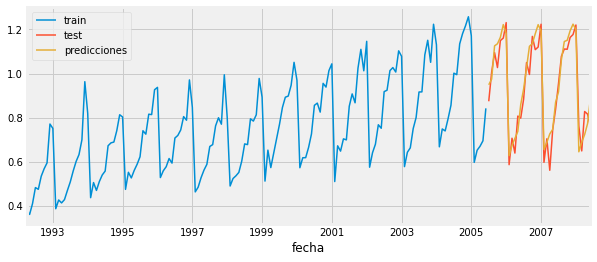

In [32]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps, exog=datos_test['exog_1'])

# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [33]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(y_true = datos_test['y'], y_pred = predicciones)
print(f"Error de test (mse) {error_mse}")

Error de test (mse) 0.0044949967759907675


# Forecasting autorregresivo recursivo con predictores custom

En determinados escenarios, puede ser interesante incorporar otras características de la serie temporal además de los lags, por ejemplo, la media movil de los últimos n valores puede servir para capturar la tendencia de la serie.

La clase ForecasterAutoregCustom se comporta de forma muy similar a la clase ForecasterAutoreg vista en los apartados anteriores pero con la diferencia de que, es el usuario, quien define la función empleada para crear los predictores.

Se repite el primer ejemplo del documento, predecir los últimos 36 meses de la serie temporal, pero esta vez, utilizando como predictores los 10 primeros lags y la media móvil de los últimos 20 meses.

# Datos

In [34]:
# Descarga de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
datos = pd.read_csv(url, sep=',')

# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos.sort_index()

# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Fechas test  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


# ForecasterAutoregCustom

Se crea y entrena un ForecasterAutoregCustom a partir de un regresor RandomForestRegressor. Para crear los predictores, se emplea la función create_predictors() que calcula los primeros 10 lags y la media móvil de los últimos 20 valores.

In [35]:
# Función para calcular los predictores a partir de la serie temporal
# ==============================================================================
def custom_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    lags = y[-1:-11:-1]
    mean = np.mean(y[-20:])
    predictors = np.hstack([lags, mean])
    
    return predictors

Al crear el forecaster, el argumento window_size debe ser un valor, como mínimo, tan grande como la ventana que utiliza la función que crea los predictores. En este caso 20.

In [36]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor(random_state=123),
                fun_predictors = custom_predictors,
                window_size    = 20
             )

forecaster.fit(y=datos_train['y'])
forecaster

ForecasterAutoregCustom 
Regressor: RandomForestRegressor(random_state=123) 
Predictors created with function: custom_predictors 
Window size: 20 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-08-09 06:51:40 
Last fit date: 2022-08-09 06:51:41 
Skforecast version: 0.4.3 

Se puede acceder al código de la función utilizada para crear lo predictores.



In [37]:
print(forecaster.source_code_create_predictors)


def custom_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    lags = y[-1:-11:-1]
    mean = np.mean(y[-20:])
    predictors = np.hstack([lags, mean])
    
    return predictors



Mediante el método create_train_X_y, se puede acceder a las matrices que se crean internamente en el proceso de entrenamiento del forecaster.

In [38]:
X, y = forecaster.create_train_X_y(y=datos_train['y'])
X.head(4)

,custom_predictor_0,custom_predictor_1,custom_predictor_2,custom_predictor_3,custom_predictor_4,custom_predictor_5,custom_predictor_6,custom_predictor_7,custom_predictor_8,custom_predictor_9,custom_predictor_10
fecha,,,,,,,,,,,
1993-12-01,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.413890,0.427283,0.387554,0.523089
1994-01-01,0.963081,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.413890,0.427283,0.552253
1994-02-01,0.819325,0.963081,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.413890,0.575129
1994-03-01,0.437670,0.819325,0.963081,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.576486


In [39]:
y.head(4)


fecha
1993-12-01    0.963081
1994-01-01    0.819325
1994-02-01    0.437670
1994-03-01    0.506121
Freq: MS, Name: y, dtype: float64

# Predicciones



In [40]:
# Predicciones
# ==============================================================================
steps = 36
predicciones = forecaster.predict(steps=steps)

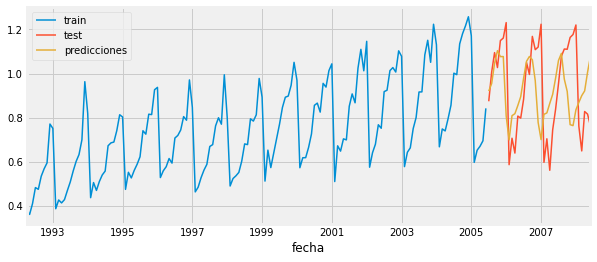

In [41]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

# Error de las predicciones en el conjunto de test



In [42]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 0.046232546768232


# Ajuste de hiperparámetros (tuning)

Al utilizar la función grid_search_forecaster con un ForecasterAutoregCustom, no se indica el argumento lags_grid.

In [43]:
# Grid search de hiperparámetros
# ==============================================================================
steps = 36
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor(random_state=123),
                fun_predictors = custom_predictors,
                window_size    = 20
             )

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train['y'],
                        param_grid  = param_grid,
                        steps       = steps,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size = False,
                        return_best = True,
                        verbose     = False
                    )

Number of models compared: 6


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:21<00:00, 21.83s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: custom predictors 
  Parameters: {'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 0.03431493238511672



In [44]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,metric,max_depth,n_estimators
3,custom predictors,"{'max_depth': 5, 'n_estimators': 500}",0.034315,5,500
2,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.035424,5,100
4,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.035572,10,100
1,custom predictors,"{'max_depth': 3, 'n_estimators': 500}",0.035790,3,500
0,custom predictors,"{'max_depth': 3, 'n_estimators': 100}",0.035878,3,100
5,custom predictors,"{'max_depth': 10, 'n_estimators': 500}",0.036010,10,500


# Modelo final

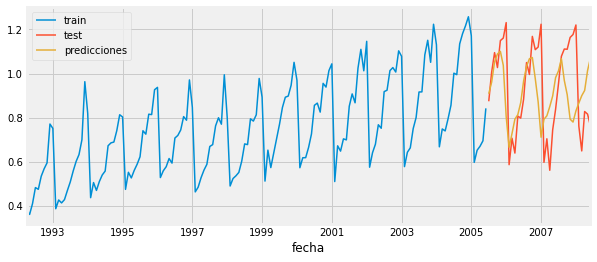

In [45]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [46]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(y_true = datos_test['y'], y_pred = predicciones)
print(f"Error de test (mse) {error_mse}")

Error de test (mse) 0.04194326997422299


# Direct multi-step forecasting

Para conseguir predicciones a varios steps a futuro, los modelos ForecasterAutoreg y ForecasterAutoregCustom siguen una estrategia de predicción recursiva en la que, cada nueva predicción, se basa en la predicción anterior. Una alternativa es entrenar un modelo para cada uno de los steps que se desea predecir. Esta estrategia, normalmente conocida como direct multi-step forecasting, es computacionalmente más costosa que la recursiva puesto que requiere entrenar varios modelos. Sin embargo, en algunos escenarios, consigue mejores resultados. Este tipo de modelos pueden obtenerse con la clase ForecasterAutoregMultiOutput y pueden incluir también una o múltiples variables exógenas.

# ForecasterAutoregMultiOutput

A diferencia de cuando se utiliza ForecasterAutoreg o ForecasterAutoregCustom, en los modelos de tipo ForecasterAutoregMultiOutput hay que indicar, en el momento de su creación, el número de steps que se quieren predecir. No es posible predecir steps más allá del valor definido en su creación.

Para este ejemplo, se utiliza como regresor un modelo lineal con penalización de Lasso. Estos modelos requieren que los predictores se estandaricen, por lo que se combina con un StandardScaler utilizando un Pipeline.

Para una documentación más detallada, visitar: skforecast-with_scikit-learn_pipelines.

In [47]:
forecaster = ForecasterAutoregMultiOutput(
                    regressor = make_pipeline(StandardScaler(), Lasso(random_state=123)),
                    steps     = 36,
                    lags      = 8
             )

forecaster

ForecasterAutoregMultiOutput 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(random_state=123))]) 
Lags: [1 2 3 4 5 6 7 8] 
Window size: 8 
Maximum steps predicted: 36 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'lasso__alpha': 1.0, 'lasso__copy_X': True, 'lasso__fit_intercept': True, 'lasso__max_iter': 1000, 'lasso__normalize': 'deprecated', 'lasso__positive': False, 'lasso__precompute': False, 'lasso__random_state': 123, 'lasso__selection': 'cyclic', 'lasso__tol': 0.0001, 'lasso__warm_start': False} 
Creation date: 2022-08-09 06:55:31 
Last fit date: None 
Skforecast version: 0.4.3 

In [48]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = make_pipeline(StandardScaler(), Lasso(random_state=123)),
                    steps     = 36,
                    lags      = 8 # Este valor será remplazado en el grid search
             )

# Para acceder a los parámetros de un pipeline de scikitlearn hay que seguir el
# patrón: <nombre del componente>__<nombre del parámetro>.
param_grid = {'lasso__alpha': np.logspace(-5, 5, 10)}
lags_grid = [5, 12, 20]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train['y'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 36,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False
                    )

Number of models compared: 30


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:13<00:00,  4.49s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'lasso__alpha': 0.021544346900318846}
  Backtesting metric: 0.010608155083112462



In [49]:
# Resultados Grid Search
# ==============================================================================
resultados_grid.head()

,lags,params,metric,lasso__alpha
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'lasso__alpha': 0.021544346900318846},0.010608,0.021544
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'lasso__alpha': 0.021544346900318846},0.012005,0.021544
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'lasso__alpha': 0.0016681005372000592},0.013960,0.001668
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'lasso__alpha': 0.0001291549665014884},0.014614,0.000129
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'lasso__alpha': 1e-05},0.014648,0.000010


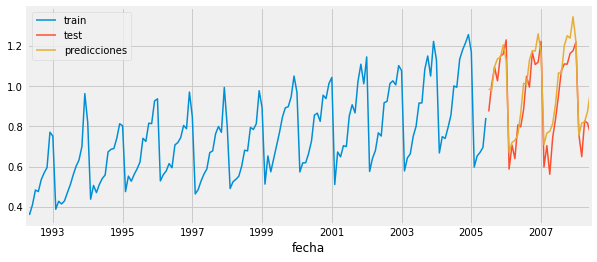

In [50]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict()

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

Los mejores resultados se obtienen utilizando una ventana temporal de 20 lags y una configuración de Lasso {'alpha': 0.021544}.

In [51]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(y_true = datos_test['y'], y_pred = predicciones)
print(f"Error de test (mse) {error_mse}")

Error de test (mse) 0.009726551142140267


# Intervalos de predicción

Un intervalo de predicción define el espacio dentro del cual es de esperar que se encuentre el verdadero valor de  y  con una determinada probabilidad. Por ejemplo, es de esperar que el intervalo de predicción (1, 99) contenga el verdadero valor de la predicción con un 98% de probabilidad.

Rob J Hyndman y George Athanasopoulos, listan en su libro Forecasting: Principles and Practice mútiples formas de estimar intervalos de predicción, la mayoría los cuales requieren que los residuos (errores) del modelo se distribuyan de forma normal. Cuando no se puede asumir esta propiedad, se puede recurrir a bootstrapping, que solo asume que los residuos no están correlacionados. Este es el método utilizado en la librería Skforecast para los modelos de tipo ForecasterAutoreg y ForecasterAutoregCustom. Puede encontrarse más detalle en skforecast prediction intervals.

In [52]:
# Descarga de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
datos = pd.read_csv(url, sep=',')

# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos.sort_index()

# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Fechas test  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


In [53]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags = 15
             )

forecaster.fit(y=datos_train['y'])

# Intervalos de predicción
# ==============================================================================
predicciones = forecaster.predict_interval(
                    steps    = steps,
                    interval = [1, 99],
                    n_boot   = 500
               )

predicciones.head(5)

,pred,lower_bound,upper_bound
2005-07-01,0.962317,0.836348,1.072365
2005-08-01,0.976595,0.786105,1.093848
2005-09-01,1.140783,0.976097,1.262243
2005-10-01,1.179538,1.009499,1.306744
2005-11-01,1.221138,1.059447,1.348892


Error de test (mse): 0.01053658052670284


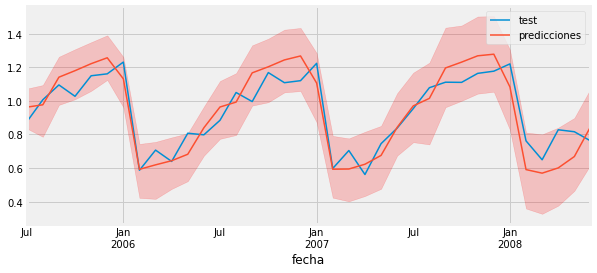

In [54]:
# Error de predicción
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones['pred']
            )

print(f"Error de test (mse): {error_mse}")

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_test['y'].plot(ax=ax, label='test')
predicciones['pred'].plot(ax=ax, label='predicciones')
ax.fill_between(
    predicciones.index,
    predicciones['lower_bound'],
    predicciones['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();

Information of backtesting process
----------------------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00

Error de test (mse): 0.012100781904923344


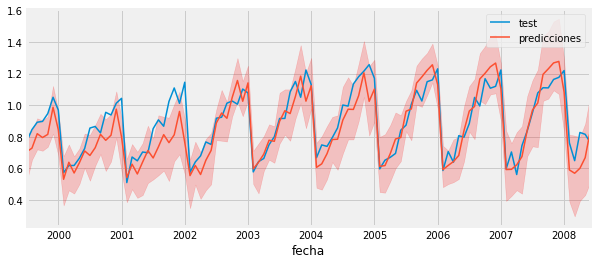

In [55]:
# Backtest con intervalos de predicción
# ==============================================================================
n_backtesting = 36*3 # Se separan para el backtest los últimos 9 años
steps = 36
forecaster = ForecasterAutoreg(
                regressor = LinearRegression(),
                lags      = 15
             )

metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = datos['y'],
                            initial_train_size = len(datos) - n_backtesting,
                            fixed_train_size   = False,
                            steps              = steps,
                            metric             = 'mean_squared_error',
                            refit              = True,
                            interval           = [1, 99],
                            n_boot             = 100,
                            verbose            = True
                       )

print(f"Error de test (mse): {metrica}")

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos.loc[predicciones.index, 'y'].plot(ax=ax, label='test')
predicciones['pred'].plot(ax=ax, label='predicciones')
ax.fill_between(
    predicciones.index,
    predicciones['lower_bound'],
    predicciones['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();

In [56]:
# Cobertura del intervalo predicho
# ==============================================================================
dentro_intervalo = np.where(
                     (datos.loc[predicciones.index, 'y'] >= predicciones['lower_bound']) & \
                     (datos.loc[predicciones.index, 'y'] <= predicciones['upper_bound']),
                     True,
                     False
                   )

cobertura = dentro_intervalo.mean()
print(f"Cobertura del intervalo predicho: {round(100*cobertura, 2)} %")

Cobertura del intervalo predicho: 84.26 %


# Métrica custom

En los procesos de backtesting (backtesting_forecaster) y optimización de hiperparámetros (grid_search_forecaster), además de las métricas mean_squared_error, mean_absolute_error y mean_absolute_percentage_error, el usuario puede utilizar cualquier función que desee siempre y cuando cumpla lo siguiente:

Tiene como argumentos:

1.   y_true: verdaderos valores de la serie.
2.   y_pred: valores predichos.

Devuelve un valor numérico (float o int).

El modelo es mejor cuanto menor es la métrica. Esto únicamente es necesario si se quiere que la función grid_search_forecaster reentrene automáticamente el mejor modelo encontrado.

Gracias a esta flexibilidad, es posible evaluar la capacidad predictiva del modelo con métricas aplicables a escenarios muy diversos. Por ejemplo:



*   Considerar únicamente determinados meses, días u horas.
*   Considerar únicamente fechas que sean festivos.
*   Considerar únicamente el último step del horizonte predicho.

Véase un ejemplo en el que se quiere predecir un horizonte de 12 meses, pero únicamente considerar los últimos 3 meses de cada año para calcular la métrica de interés.

In [57]:
# Métrica custom 
# ==============================================================================
from sklearn.metrics import mean_absolute_error

def custom_metric(y_true, y_pred):
    '''
    Calcular el mean_absolute_error utilizando únicamente las predicciones de
    los últimos 3 meses del año.
    '''
    mask = y_true.index.month.isin([10, 11, 12])
    metric = mean_absolute_error(y_true[mask], y_pred[mask])
    
    return metric

In [59]:
# Backtesting 
# ==============================================================================
steps = 36
n_backtesting = 36*3 # Se separan para el backtest los últimos 9 años

metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = datos['y'],
                                    initial_train_size = len(datos) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = custom_metric,
                                    verbose            = True
                                 )

print(f"Error de backtest: {metrica}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00

Error de backtest: 0.12033751744029476
Information of backtesting process
----------------------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-

# Cargar y guardar modelos

Los modelos generados con Skforecast se pueden cargar y guardar usando las librerías Pickle o Joblib. A continuación se muestra un ejemplo sencillo utilizando Joblib.

https://joaquinamatrodrigo.github.io/skforecast/0.4.3/notebooks/save-load-forecaster.html

In [60]:
# Crear forecaster
forecaster = ForecasterAutoreg(RandomForestRegressor(random_state=123), lags=3)
forecaster.fit(y=datos['y'])
forecaster.predict(steps=3)

2008-07-01    0.751967
2008-08-01    0.826505
2008-09-01    0.879444
Freq: MS, Name: pred, dtype: float64

In [61]:
# Guardar modelo
dump(forecaster, filename='forecaster.py')

['forecaster.py']

In [62]:
# Cargar modelo
forecaster_cargado = load('forecaster.py')

In [63]:
# Predicciones
forecaster_cargado.predict(steps=3)

2008-07-01    0.751967
2008-08-01    0.826505
2008-09-01    0.879444
Freq: MS, Name: pred, dtype: float64

# Uso de modelos en producción

En los proyectos relacionados con forecasting es frecuente que, como resultado de la etapa de experimentación y desarrollo, se genere un modelo. Para que este modelo consiga un impacto real en el negocio, se tiene que poder poner en producción y generar predicciones cada cierto tiempo, con las que tomar decisiones. Esta necesidad ha guiado en gran medida el desarrollo de la librería Skforecast.

Supóngase un caso de uso en el que se han de generar predicciones de forma semanal, por ejemplo, cada lunes el modelo tiene que predecir el resto de la semana. Una forma de conseguir este comportamiento es reentrenando el modelo semanalmente justo antes de que se ejecute la primera predicción y llamar a continuación al método predict del objeto forecaster.

Esta estrategia, si bien es sencilla, puede no ser posible de utilizar en la práctica por varias razones:




*   El entrenamiento del modelo es muy costoso y no puede ejecutarse con tanta frecuencia.
*   Ya no se dispone del histórico con el que se entrenó el modelo.
*   La frecuencia de predicción es tan elevada que no se dispone de tiempo para entrenar el modelo entre predicción y predicción.

En estos casos, es necesario que el modelo pueda ejecutarse en cualquier momento aunque no se haya entrenado recientemente.

Todos los modelos generados por la librería Skforecast disponen en su método predict del argumento last_window. Gracias a él, se pueden proporcionar únicamente los valores pasados que necesita el modelo para crear los predictores autorregresivos (lags) y así generar las predicciones sin necesidad de reentrenar el modelo.


https://joaquinamatrodrigo.github.io/skforecast/0.4.3/notebooks/forecaster-in-production.html

In [64]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )

forecaster.fit(y=datos_train['y'])

En este caso, dado que el modelo utiliza como predictores los últimos 6 lags, last_window debe de contener como mínimo los 6 valores previos al momento donde se quiere iniciar la predicción.



In [65]:
last_window = datos_test['y'][-6:]
forecaster.predict(last_window=last_window, steps=4)

2008-07-01    0.757750
2008-08-01    0.836313
2008-09-01    0.877668
2008-10-01    0.911734
Freq: MS, Name: pred, dtype: float64

Si el forecaster utiliza variables exógenas, además de last_window, se le deben proporcionar los valores futuros de las variables exógenas mediante el argumento exog.

https://www.cienciadedatos.net/documentos/py27-forecasting-series-temporales-python-scikitlearn.html#Ajuste-de-hiperpar%C3%A1metros-(tuning)